In [3]:
#기본 모듈
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib as mpl

#폰트 관련 모듈
from matplotlib import rc
import matplotlib.font_manager as fm

#전처리 모듈
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

#모델 임포트
import xgboost as xgb

#모델 평가
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

In [2]:
#폰트 지정 
font_path = "C:/Windows/Fonts/malgun.ttf"

font = fm.FontProperties(fname=font_path).get_name()
rc('font', family=font)
mpl.rcParams['axes.unicode_minus'] = False #마이너스 기호 처리

In [4]:
#데이터 적재
train_data = pd.read_csv("../Data/electric_train.csv")
train_data.head()


,Unnamed: 0,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec
0,1,4821,2021-01-01 01:00:00,1,11,884,6950,751.32,68.606449,2.2,62.7,1.8,0.0,-1.0,4,0,99.56
1,2,4821,2021-01-01 02:00:00,2,11,884,6950,692.60,68.606449,2.3,63.1,2.1,0.0,-0.6,4,0,91.78
2,3,4821,2021-01-01 03:00:00,3,11,884,6950,597.48,68.606449,2.2,62.4,2.5,0.0,-1.3,4,0,79.17
3,4,4821,2021-01-01 04:00:00,4,11,884,6950,553.48,68.606449,1.7,63.5,1.7,0.0,-0.2,4,0,73.34
4,5,4821,2021-01-01 05:00:00,5,11,884,6950,526.24,68.606449,1.7,63.0,1.6,0.0,-0.8,4,0,69.73


In [5]:
#자료형 확인하기
type(train_data)

pandas.core.frame.DataFrame

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7593355 entries, 0 to 7593354
Data columns (total 17 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Unnamed: 0                  int64  
 1   electric_train.num          int64  
 2   electric_train.tm           object 
 3   electric_train.hh24         int64  
 4   electric_train.n            int64  
 5   electric_train.stn          int64  
 6   electric_train.sum_qctr     int64  
 7   electric_train.sum_load     float64
 8   electric_train.n_mean_load  float64
 9   electric_train.nph_ta       float64
 10  electric_train.nph_hm       float64
 11  electric_train.nph_ws_10m   float64
 12  electric_train.nph_rn_60m   float64
 13  electric_train.nph_ta_chi   float64
 14  electric_train.weekday      int64  
 15  electric_train.week_name    int64  
 16  electric_train.elec         float64
dtypes: float64(8), int64(8), object(1)
memory usage: 984.9+ MB


In [7]:
#결측치 확인하기: 기상 데이터의 -99값은 결측치를 의미
print((train_data.values == -99).sum())
#, print((test_data.values == -99).sum())

174


In [10]:
#풍속 결측치 확인
print((train_data['electric_train.nph_ws_10m'].values == -99).sum())
#, print((test_data['electric_test.nph_ws_10m'].values == -99).sum())

169


In [13]:
#전력기상지수 결측치 확인
print((train_data['electric_train.elec'].values == -99).sum())

5


In [14]:
#결측치 nan값으로 바꿔주기
train_data['electric_train.elec'] = train_data['electric_train.elec'].replace(-99, np.nan)
train_data['electric_train.nph_ws_10m'] = train_data['electric_train.nph_ws_10m'].replace(-99, np.nan)

In [15]:
#replace가 제대로 됐는지 확인
#replace한 데이터를 해당 열에 저장해줘야 함 X[] = X[].replace(,)
print(train_data.isnull().sum())

Unnamed: 0                      0
electric_train.num              0
electric_train.tm               0
electric_train.hh24             0
electric_train.n                0
electric_train.stn              0
electric_train.sum_qctr         0
electric_train.sum_load         0
electric_train.n_mean_load      0
electric_train.nph_ta           0
electric_train.nph_hm           0
electric_train.nph_ws_10m     169
electric_train.nph_rn_60m       0
electric_train.nph_ta_chi       0
electric_train.weekday          0
electric_train.week_name        0
electric_train.elec             5
dtype: int64


In [16]:
#선형보간법을 수행하기 위해 시계열 데이터를 인덱스로 지정
train_data['electric_train.tm'] = pd.to_datetime(train_data['electric_train.tm'])
train_data.set_index(train_data['electric_train.tm'], inplace=True)
train_data.head()

,Unnamed: 0,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec
electric_train.tm,,,,,,,,,,,,,,,,,
2021-01-01 01:00:00,1,4821,2021-01-01 01:00:00,1,11,884,6950,751.32,68.606449,2.2,62.7,1.8,0.0,-1.0,4,0,99.56
2021-01-01 02:00:00,2,4821,2021-01-01 02:00:00,2,11,884,6950,692.60,68.606449,2.3,63.1,2.1,0.0,-0.6,4,0,91.78
2021-01-01 03:00:00,3,4821,2021-01-01 03:00:00,3,11,884,6950,597.48,68.606449,2.2,62.4,2.5,0.0,-1.3,4,0,79.17
2021-01-01 04:00:00,4,4821,2021-01-01 04:00:00,4,11,884,6950,553.48,68.606449,1.7,63.5,1.7,0.0,-0.2,4,0,73.34
2021-01-01 05:00:00,5,4821,2021-01-01 05:00:00,5,11,884,6950,526.24,68.606449,1.7,63.0,1.6,0.0,-0.8,4,0,69.73


In [17]:
#선형보간법으로 결측치 처리
train_data['electric_train.nph_ws_10m'] = train_data['electric_train.nph_ws_10m'].interpolate(method='time')
train_data['electric_train.elec'] = train_data['electric_train.elec'].interpolate(method='time')
train_data.reset_index(drop=True, inplace=True) #인덱스 되돌리기
print(train_data.isnull().sum())

Unnamed: 0                    0
electric_train.num            0
electric_train.tm             0
electric_train.hh24           0
electric_train.n              0
electric_train.stn            0
electric_train.sum_qctr       0
electric_train.sum_load       0
electric_train.n_mean_load    0
electric_train.nph_ta         0
electric_train.nph_hm         0
electric_train.nph_ws_10m     0
electric_train.nph_rn_60m     0
electric_train.nph_ta_chi     0
electric_train.weekday        0
electric_train.week_name      0
electric_train.elec           0
dtype: int64


In [18]:
#날짜 데이터를 연도와 월로 분리하여 새로운 열로 추가->sin/cos변환
train_data['electric_train.yy'] = train_data['electric_train.tm'].dt.year
train_data['electric_train.mm'] = train_data['electric_train.tm'].dt.month
train_data['electric_train.dd'] = train_data['electric_train.tm'].dt.day

In [19]:
#이산형변수 sin, cos 변환
train_data['sin_time'] = np.sin(2*np.pi*train_data['electric_train.hh24']/24)
train_data['cos_time'] = np.cos(2*np.pi*train_data['electric_train.hh24']/24)
train_data.head()

,Unnamed: 0,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,...,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec,electric_train.yy,electric_train.mm,electric_train.dd,sin_time,cos_time
0,1,4821,2021-01-01 01:00:00,1,11,884,6950,751.32,68.606449,2.2,...,0.0,-1.0,4,0,99.56,2021,1,1,0.258819,0.965926
1,2,4821,2021-01-01 02:00:00,2,11,884,6950,692.60,68.606449,2.3,...,0.0,-0.6,4,0,91.78,2021,1,1,0.500000,0.866025
2,3,4821,2021-01-01 03:00:00,3,11,884,6950,597.48,68.606449,2.2,...,0.0,-1.3,4,0,79.17,2021,1,1,0.707107,0.707107
3,4,4821,2021-01-01 04:00:00,4,11,884,6950,553.48,68.606449,1.7,...,0.0,-0.2,4,0,73.34,2021,1,1,0.866025,0.500000
4,5,4821,2021-01-01 05:00:00,5,11,884,6950,526.24,68.606449,1.7,...,0.0,-0.8,4,0,69.73,2021,1,1,0.965926,0.258819


In [20]:
#컬럼 순서 변경
train_data = train_data[['electric_train.num', 'electric_train.yy', 'electric_train.mm', 'electric_train.dd', 'electric_train.hh24', 'electric_train.weekday', 'electric_train.week_name', 'electric_train.n', 'electric_train.stn', 'electric_train.sum_qctr',	'electric_train.sum_load', 'electric_train.n_mean_load', 'electric_train.nph_ta', 'electric_train.nph_hm', 'electric_train.nph_ws_10m',	'electric_train.nph_rn_60m', 'electric_train.nph_ta_chi', 'electric_train.elec', 'sin_time', 'cos_time']]
train_data.head()

,electric_train.num,electric_train.yy,electric_train.mm,electric_train.dd,electric_train.hh24,electric_train.weekday,electric_train.week_name,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.elec,sin_time,cos_time
0,4821,2021,1,1,1,4,0,11,884,6950,751.32,68.606449,2.2,62.7,1.8,0.0,-1.0,99.56,0.258819,0.965926
1,4821,2021,1,1,2,4,0,11,884,6950,692.60,68.606449,2.3,63.1,2.1,0.0,-0.6,91.78,0.500000,0.866025
2,4821,2021,1,1,3,4,0,11,884,6950,597.48,68.606449,2.2,62.4,2.5,0.0,-1.3,79.17,0.707107,0.707107
3,4821,2021,1,1,4,4,0,11,884,6950,553.48,68.606449,1.7,63.5,1.7,0.0,-0.2,73.34,0.866025,0.500000
4,4821,2021,1,1,5,4,0,11,884,6950,526.24,68.606449,1.7,63.0,1.6,0.0,-0.8,69.73,0.965926,0.258819


In [21]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7593355 entries, 0 to 7593354
Data columns (total 20 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   electric_train.num          int64  
 1   electric_train.yy           int32  
 2   electric_train.mm           int32  
 3   electric_train.dd           int32  
 4   electric_train.hh24         int64  
 5   electric_train.weekday      int64  
 6   electric_train.week_name    int64  
 7   electric_train.n            int64  
 8   electric_train.stn          int64  
 9   electric_train.sum_qctr     int64  
 10  electric_train.sum_load     float64
 11  electric_train.n_mean_load  float64
 12  electric_train.nph_ta       float64
 13  electric_train.nph_hm       float64
 14  electric_train.nph_ws_10m   float64
 15  electric_train.nph_rn_60m   float64
 16  electric_train.nph_ta_chi   float64
 17  electric_train.elec         float64
 18  sin_time                    float64
 19  cos_time             

### y값 구하기

In [22]:
# 필요한 데이터만 추출하기(분자)
grid_elec = train_data[['electric_train.num', 'electric_train.yy', 'electric_train.hh24', 'electric_train.sum_load']]
grid_elec.head()

,electric_train.num,electric_train.yy,electric_train.hh24,electric_train.sum_load
0,4821,2021,1,751.32
1,4821,2021,2,692.60
2,4821,2021,3,597.48
3,4821,2021,4,553.48
4,4821,2021,5,526.24


In [23]:
#분모: 격자별, 년도별, 시간별 평균 전력 수요
den = grid_elec.groupby([grid_elec['electric_train.yy'], grid_elec['electric_train.hh24'], grid_elec['electric_train.num']]).mean()
#type(den)
den

electric_train.sum_load
electric_train.yy electric_train.hh24 electric_train.num                         
2020              1                   5565                            4423.837268
                                      5566                            1795.328634
                                      5567                            2569.287322
                                      9735                            2542.317705
                                      9736                            1522.596284
...                                                                           ...
2023              24                  19612                           4831.720000
                                      19741                           8623.120000
                                      19878                           5305.280000
                                      19890                           5414.000000
                                      20947                           5969.720000

[21115 rows x 1 columns]

### y값을 포함하는 테이블 생성하기

In [24]:
#y
y_table = pd.merge(grid_elec, den, on=['electric_train.num', 'electric_train.yy', 'electric_train.hh24'], how='outer')
y_table.head()

,electric_train.num,electric_train.yy,electric_train.hh24,electric_train.sum_load_x,electric_train.sum_load_y
0,4821,2021,1,751.32,717.475616
1,4821,2021,1,707.48,717.475616
2,4821,2021,1,720.96,717.475616
3,4821,2021,1,683.56,717.475616
4,4821,2021,1,715.40,717.475616


In [25]:
#열 이름 바꾸기
y_table.rename(columns={'electric_train.sum_load_x' : 'electric_train.sum_load', 'electric_train.sum_load_y': 'electric_train.mean_load_g'}, inplace=True)
y_table.head()

,electric_train.num,electric_train.yy,electric_train.hh24,electric_train.sum_load,electric_train.mean_load_g
0,4821,2021,1,751.32,717.475616
1,4821,2021,1,707.48,717.475616
2,4821,2021,1,720.96,717.475616
3,4821,2021,1,683.56,717.475616
4,4821,2021,1,715.40,717.475616


In [26]:
#y값을 새로운 열로 추가하기
y_table['electric_train.elec'] = y_table['electric_train.sum_load']/y_table['electric_train.mean_load_g']*100
y_table.head()

,electric_train.num,electric_train.yy,electric_train.hh24,electric_train.sum_load,electric_train.mean_load_g,electric_train.elec
0,4821,2021,1,751.32,717.475616,104.717148
1,4821,2021,1,707.48,717.475616,98.606835
2,4821,2021,1,720.96,717.475616,100.485645
3,4821,2021,1,683.56,717.475616,95.272924
4,4821,2021,1,715.40,717.475616,99.710706


### train, valid data split

In [27]:
#y_table에서 정답지만 뽑기
X = train_data
y = y_table['electric_train.elec']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Modeling: XGBRegressor

In [29]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [30]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 7.546113445152426


In [31]:
#제출하는 데이터(정답지랑 비교함)
y_pred

array([104.45323,  94.33037, 106.69108, ...,  96.89211,  94.7417 ,
        85.76599], dtype=float32)

In [32]:
X_test

,electric_train.num,electric_train.yy,electric_train.mm,electric_train.dd,electric_train.hh24,electric_train.weekday,electric_train.week_name,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.elec,sin_time,cos_time
3895001,16303,2022,3,18,20,4,0,37,493,77800,13890.12,297.010668,4.9,81.6,1.2,0.0,7.6,126.40,-8.660254e-01,0.500000
5067316,18092,2021,11,29,8,0,0,15,459,17100,2268.40,156.725721,3.5,70.2,0.5,0.0,0.0,96.49,8.660254e-01,-0.500000
1720259,11718,2022,3,12,13,5,1,13,257,45100,6340.08,495.260942,18.0,63.9,1.8,0.0,20.7,98.47,-2.588190e-01,-0.965926
2417038,13352,2021,8,30,24,0,0,59,827,81900,14229.28,217.623033,26.8,88.8,0.9,0.0,25.7,110.82,-2.449294e-16,1.000000
3567105,15714,2020,10,26,12,0,0,52,327,62419,9705.48,234.970990,18.9,44.2,1.1,0.0,16.4,79.43,1.224647e-16,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559520,15713,2022,12,15,11,3,0,32,131,50200,7254.40,248.131004,-0.1,45.2,0.2,0.0,-3.3,91.36,2.588190e-01,-0.965926
2673978,13615,2022,12,18,21,6,1,24,140,37900,11313.48,332.300400,-12.6,84.9,0.1,0.0,-9.4,141.86,-7.071068e-01,0.707107
2111269,13176,2022,10,15,15,5,1,11,864,15200,2315.96,249.212728,24.4,48.9,0.6,0.0,25.1,84.48,-7.071068e-01,-0.707107
1310183,11273,2020,6,5,24,4,0,194,940,232843,32515.56,161.848442,18.7,79.9,1.0,0.0,23.4,103.56,-2.449294e-16,1.000000


In [33]:
y_test

3895001    110.088887
5067316     95.082514
1720259    103.513166
2417038     90.717833
3567105    159.676072
              ...    
3559520     98.757465
2673978     99.458261
2111269     98.101450
1310183     91.985166
7040152     86.166432
Name: electric_train.elec, Length: 2278007, dtype: float64

In [34]:
y_pred

array([104.45323,  94.33037, 106.69108, ...,  96.89211,  94.7417 ,
        85.76599], dtype=float32)

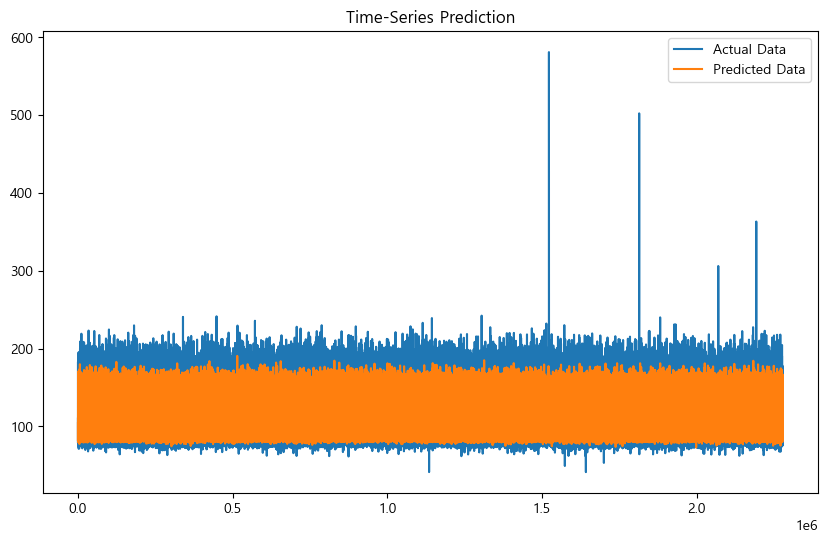

In [35]:
# 전체 데이터셋 시각화
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Data')
plt.plot(y_pred, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()